**Tải bộ dữ liệu**

In [1]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

D:\Miniconda3\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=7ad022fb-ad17-4acd-9a34-a201cd8007f8
To: d:\AIO2024\module_5\week_3\FER-2013.zip

  0%|          | 0.00/63.3M [00:00<?, ?B/s]
  1%|          | 524k/63.3M [00:00<00:25, 2.42MB/s]
  3%|▎         | 2.10M/63.3M [00:00<00:08, 7.05MB/s]
 12%|█▏        | 7.34M/63.3M [00:00<00:02, 22.0MB/s]
 17%|█▋        | 10.5M/63.3M [00:00<00:03, 15.7MB/s]
 20%|█▉        | 12.6M/63.3M [00:00<00:03, 13.4MB/s]
 27%|██▋       | 16.8M/63.3M [00:01<00:02, 19.0MB/s]
 32%|███▏      | 20.4M/63.3M [00:01<00:01, 21.7MB/s]
 37%|███▋      | 23.6M/63.3M [00:01<00:01, 23.8MB/s]
 42%|████▏     | 26.7M/63.3M [00:01<00:01,

In [3]:
import zipfile

file_path = "FER-2013.zip"
extract_to = "./FER-2013"

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
    print(f"Tệp được giải nén vào {extract_to}")

Tệp được giải nén vào ./FER-2013


**Import các thư viện cần thiết**

In [4]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán**

In [5]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_state)

**Đọc số lượng class trong dataset**

In [6]:
train_dir = "./FER-2013/train"
test_dir = "./FER-2013/test"

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for idx, cls in enumerate(classes)}

In [7]:
img = cv2.imread(os.path.join(train_dir, classes[0], os.listdir(os.path.join(train_dir, classes[0]))[0]))
img_height, img_width, _ = img.shape
img_height, img_width

(48, 48)

**Xây dựng DataLoader**

In [8]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths, img_labels = [], []
        for cls in classes:
            img_cls_dir = os.path.join(self.img_dir, cls)
            for img_name in os.listdir(img_cls_dir):
                img_paths.append(os.path.join(img_cls_dir, img_name))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1

        return img, label

In [9]:
batch_size = 256
train_dataset = ImageDataset(train_dir, norm=True, label2idx=label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, norm=True, label2idx=label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, norm=True, label2idx=label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

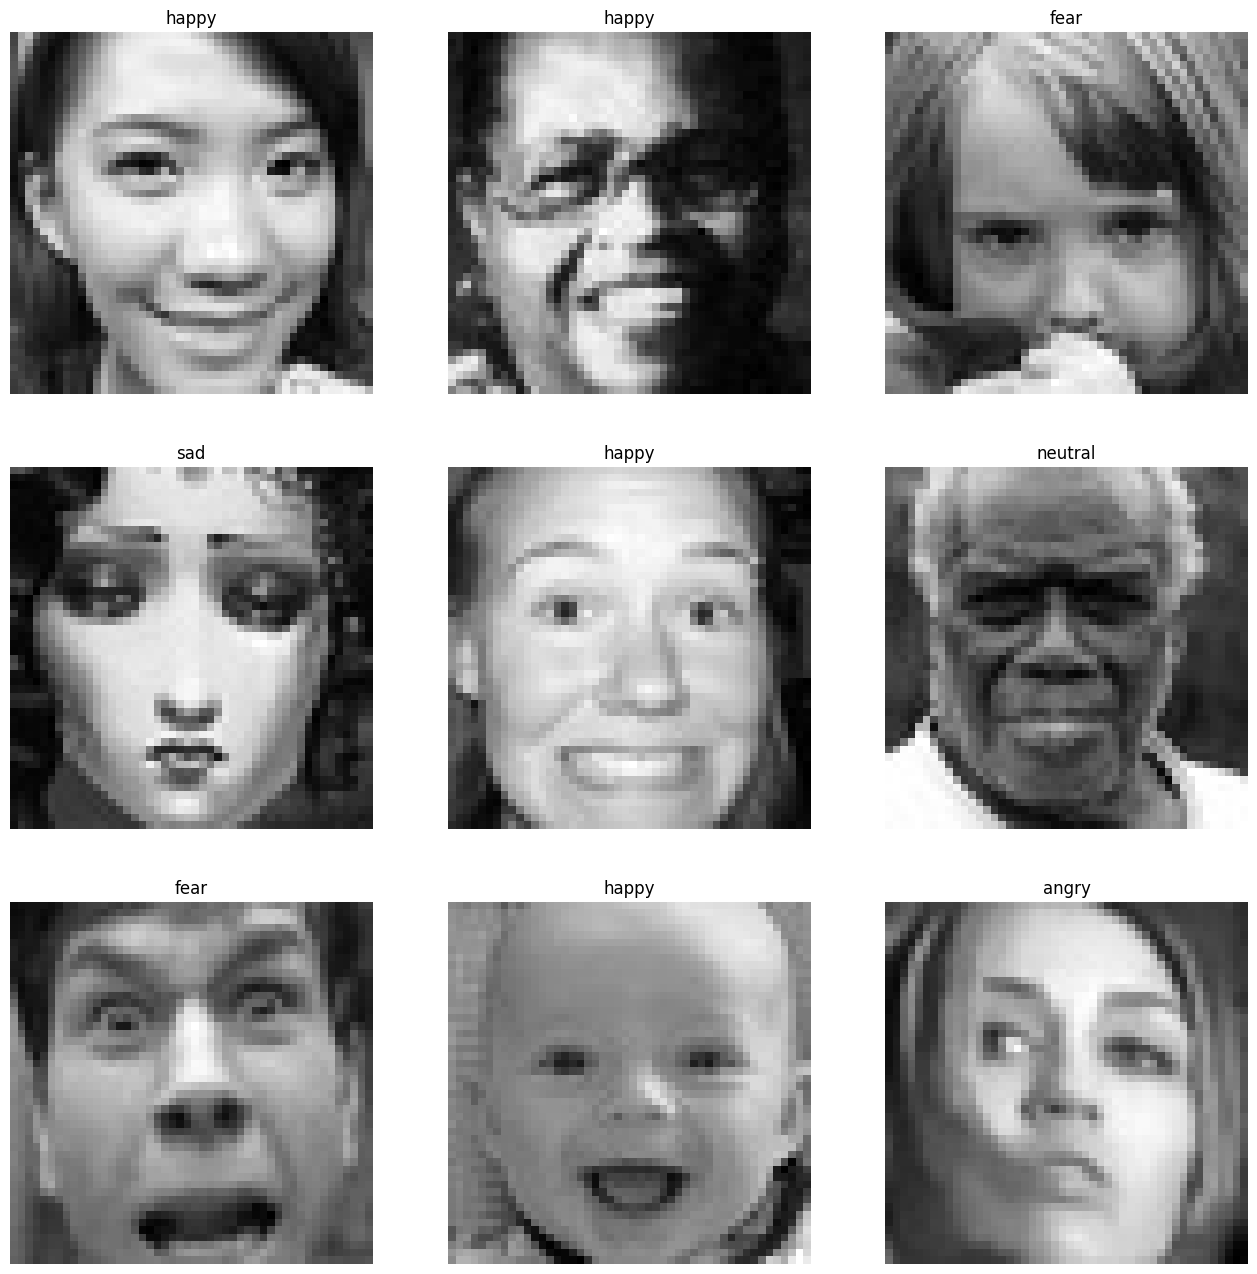

In [10]:
image_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(16, 16))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), cmap='gray', vmin=minv, vmax=maxv)
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

**Xây dựng mạng MLP**

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.output(x)
        return x

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64

lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

**Xây dựng hàm tính độ chính xác**

In [29]:
def compute_accuracy(y_hat, y_true):
    correct = (y_hat == y_true).sum().item()
    return correct / len(y_true)

**Huấn luyện mô hình**

In [33]:
epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0
    train_target = []
    train_pred = []

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_target.extend(labels.tolist())
        train_pred.extend(torch.argmax(outputs, dim=1).tolist())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = compute_accuracy(torch.tensor(train_pred), torch.tensor(train_target))
    train_accs.append(train_acc)

    val_loss = 0
    val_target = []
    val_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_target.extend(labels.cpu().numpy())
            val_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_acc = compute_accuracy(torch.tensor(val_pred), torch.tensor(val_target))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/40, Train Loss: 1.8571, Train Acc: 0.2513, Val Loss: 1.8476, Val Acc: 0.2513
Epoch 2/40, Train Loss: 1.8373, Train Acc: 0.2513, Val Loss: 1.8308, Val Acc: 0.2513
Epoch 3/40, Train Loss: 1.8219, Train Acc: 0.2513, Val Loss: 1.8183, Val Acc: 0.2513
Epoch 4/40, Train Loss: 1.8103, Train Acc: 0.2513, Val Loss: 1.8087, Val Acc: 0.2513
Epoch 5/40, Train Loss: 1.8012, Train Acc: 0.2517, Val Loss: 1.8011, Val Acc: 0.2529
Epoch 6/40, Train Loss: 1.7937, Train Acc: 0.2544, Val Loss: 1.7950, Val Acc: 0.2586
Epoch 7/40, Train Loss: 1.7876, Train Acc: 0.2585, Val Loss: 1.7898, Val Acc: 0.2593
Epoch 8/40, Train Loss: 1.7826, Train Acc: 0.2599, Val Loss: 1.7853, Val Acc: 0.2590
Epoch 9/40, Train Loss: 1.7781, Train Acc: 0.2621, Val Loss: 1.7813, Val Acc: 0.2590
Epoch 10/40, Train Loss: 1.7740, Train Acc: 0.2625, Val Loss: 1.7775, Val Acc: 0.2604
Epoch 11/40, Train Loss: 1.7702, Train Acc: 0.2635, Val Loss: 1.7737, Val Acc: 0.2612
Epoch 12/40, Train Loss: 1.7662, Train Acc: 0.2674, Val Loss: 1

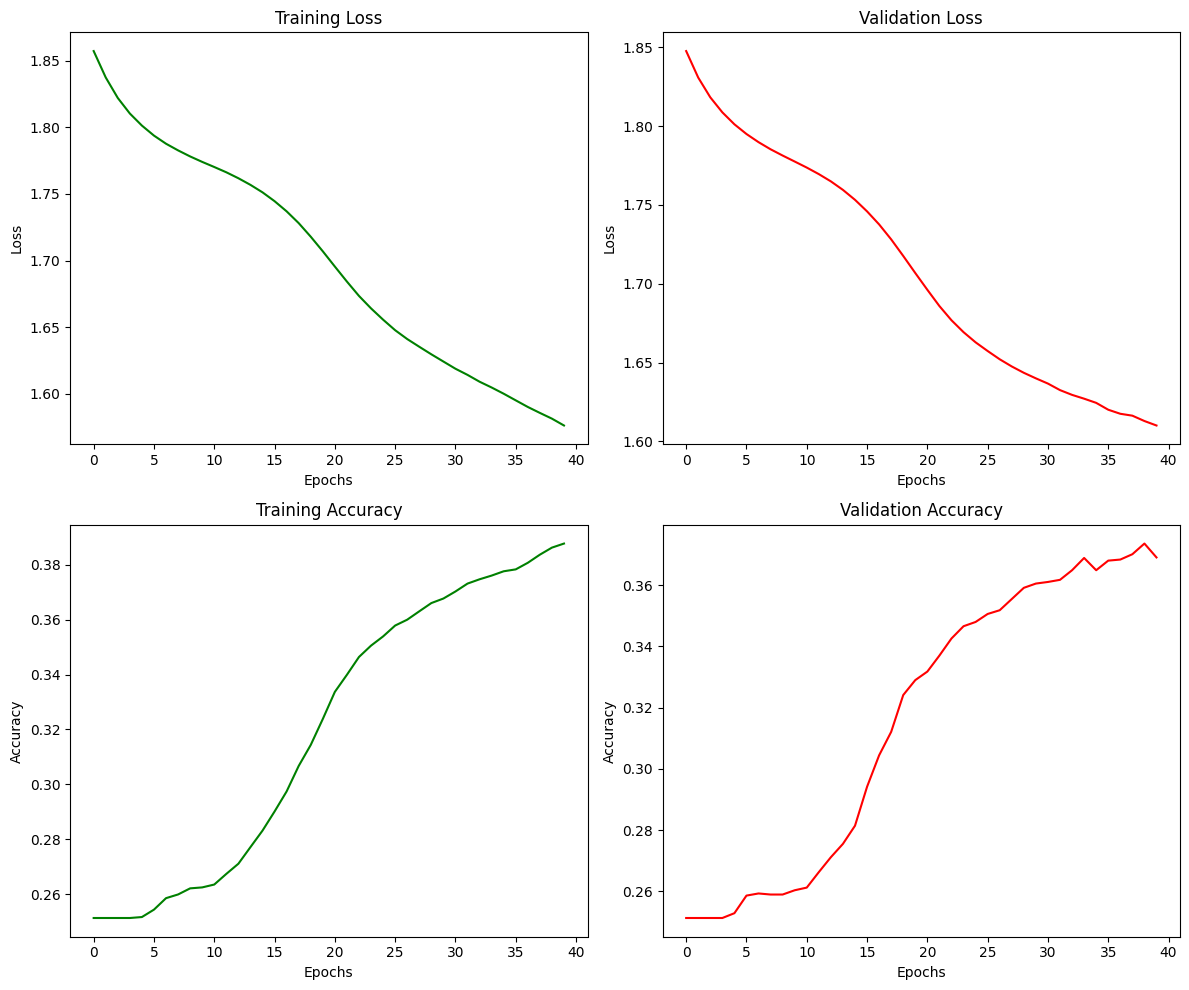

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='g')
ax[0, 0].set(xlabel='Epochs', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='r')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='g')
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='r')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

**Huấn luyện mô hình**

In [35]:
test_target = []
test_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        test_target.extend(labels.cpu().numpy())
        test_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_acc = compute_accuracy(torch.tensor(test_pred), torch.tensor(test_target))
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.3845
